In [47]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.signal import spectrogram
from cmath import cos, sin, pi
import math
from math import sqrt
import mne
from mne import io

In [49]:
# Plot and save the PSD of the signal
# f, PSD_eeg = PSD_cp(eeg_filtered,fs,False,target_frequencies,chan_name)
def PSD_cp(eeg_data,fs,plot,n_nperseg,chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']):
    # Compute the PSD of the filtered signal
    f, Pxx_den = signal.welch(eeg_data, fs, nperseg=n_nperseg*fs)
    
    if (plot == True):
        # Plot the PSD for each channel of the filtered signal
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('PSD of the signal')
        for i in range(len(eeg_data)):
            axs[i//3, i%3].semilogy(f[0:201], Pxx_den[i][0:201])
            axs[i//3, i%3].set_xlabel('Frequency (Hz)')
            axs[i//3, i%3].set_ylabel('PSD [V**2/Hz]')
            axs[i//3, i%3].set_title(chan_name[i])
            plt.subplots_adjust(hspace=0.5, wspace=0.5)
        plt.show()
    return f, Pxx_den

In [50]:
# Plot and save the Spectrogram of the signal 
#freqs, t, Sxx = spectrogram_cp(eeg_filtered,fs,f_range,False,chan_name)
def spectrogram_cp(eeg_data,fs,f_range,plot,n_nperseg,n_noverlap,chan_name = ['PO3','POz','PO4', 'O1', 'Oz', 'O2']):
    # Define parameters for spectrogram
    nperseg = int(fs*n_nperseg)  # Number of samples per segment
    noverlap = int(fs*n_noverlap)  # Number of samples overlapping between segments

    # Define empty arrays to store the spectrogram for each channel
    freqs = []
    t = []
    Sxx = []
    
    # Loop through each channel
    for channel_index in range(len(eeg_data)):
        # Calculate the spectrogram for current channel and store the results in the arrays
        freqs_current, t_current, Sxx_current = spectrogram(eeg_data[channel_index], fs, nperseg=nperseg, noverlap=noverlap)
        # Select the frequency range of interest
        freq_idx = (freqs_current >= f_range[0]) & (freqs_current <= f_range[1])
        freqs_current = freqs_current[freq_idx]
        Sxx_current = Sxx_current[freq_idx, :]
        # Append the results to the arrays
        freqs.append(freqs_current)
        t.append(t_current)
        Sxx.append(Sxx_current)
     
        
    if (plot == True): 
        # Plot the spectrogram in a 2x3 grid 
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Spectrogram of the signal')
        for i in range(len(eeg_data)):
            im = axs[i//3, i%3].pcolormesh(t[i], freqs[i], 10 * np.log10(Sxx[i]), cmap='jet')
            fig.colorbar(im, ax=axs[i//3, i%3], label='dB/Hz')
            axs[i//3, i%3].set_xlabel('Time (s)')
            axs[i//3, i%3].set_ylabel('Frequency (Hz)')
            axs[i//3, i%3].set_title('Spectrogram for Channel ' + chan_name[i])
        fig.subplots_adjust(wspace=0.5, hspace=0.5, bottom=0.15)
        plt.show()   
        
    # Convert the arrays to numpy arrays
    freqs = np.array(freqs)
    t = np.array(t)
    Sxx = np.array(Sxx)
    return freqs, t, Sxx

In [51]:
def freq_snr(Pxx_den, f, frequency_interest, frequencies_interest):
    # Find the index of the frequency of interest
    idx_interest = np.argmin(np.abs(f - frequency_interest))
    # Find the indices of the frequencies of interest
    idx_interests = []
    for freq in frequencies_interest:
        idx_interests.append(np.argmin(np.abs(f - freq)))
    # Calculate the power at the frequency of interest
    power_interest = Pxx_den[:, idx_interest]
    # Calculate the total power at the frequencies of interest
    total_power_interests = np.sum(Pxx_den[:, idx_interests], axis=1)
    # Calculate the ratio of power at frequency of interest to the total power at frequencies of interest
    ratio = power_interest / total_power_interests
    return ratio

In [52]:
# Paper rls filter function
def rls_filter(y, f,lambda_, fs, delta):
    # Recursive Least Squares (RLS) filter from the paper : https://pubmed.ncbi.nlm.nih.gov/7750452/
    # An adaptive filter for steady-state evoked responses.
    
    # y is the input signal -> EEG signal in our case. But in the paper y is interpreted as the desired signal.
    # x is the frequency of interest.
    # P is the number of filter coefficients -> our case fixed at 2. In terms of RLS filter, 
    # the number of coefficients is actually 1 since we only work with most recent sample
    P = 2
    # lambda_ is the forgetting factor. Usually between 0.9 and 0.999
    # delta is the initial value of the inverse correlation matrix. Usually some small value like 0.001
    
    # Initialize the filter coefficients. P is fixed at 2 in our case.
    w_all = np.zeros([P, len(y)])
    
    #Initialize the desired signal. This the paper interprets as the input signal.
    x1 = np.zeros([len(y),1]) 
    x2 = np.zeros([len(y),1])
    x = np.zeros([2,len(y)])
    # Make x1 a sine of the desired frequency f
    x1 = np.sin(2*np.pi*f*np.arange(0,len(y),1)/fs)
    # Make x2 a cosine of the desired frequency f
    x2 = np.cos(2*np.pi*f*np.arange(0,len(y),1)/fs)
    # Stack x1 and x2 to make x
    x = np.vstack((x1,x2)) 
    
    # Initialize the inverse correlation matrix as a numpy array
    R = delta*np.eye(P) 
    
    # Initialize the output signal
    y_hat = np.zeros([len(y),1])
    
    # Initialize the error signal
    e = np.zeros([len(y),1])
    
    # Loop through the samples one by one
    for i in range(0,len(y)):
        
        # 1. Compute the adaptation gain
        k_num = (1/lambda_)*(R@x[:,i])  
        k_den = 1 + (1/lambda_)*(x[:,i].T@R@x[:,i])
        k  = k_num/k_den
        k = np.reshape(k, (P,1))

        # 2. Error signal & update signal estimate
        y_hat[i] = (w_all[:,i-1].T)@x[:,i]
        e[i] = y[i] - y_hat[i] 
        
        # 3. Update the filter coefficients
        w_all[:,i] = w_all[:,i-1] + k@e[i]
    
        # 4. Update the inverse correlation matrix
        x_temp = np.reshape(x[:,i], (2,1))
        R = (1/lambda_) * R - (1/lambda_)* k@x_temp.T@R     
        
    return y_hat,w_all

In [53]:
# new_array = correct_size(array)
def correct_size(arr):
    # Check if the input is a valid NumPy array
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    # Get the length of the array
    number = arr.shape[1]

    # Find the logarithm base 2 of the number
    log2_number = math.log2(number)

    # Calculate the lower and upper powers of two
    lower_power_of_two = 2 ** math.floor(log2_number)
    upper_power_of_two = 2 ** math.ceil(log2_number)

    # Calculate the distances to the lower and upper powers of two
    distance_lower = abs(number - lower_power_of_two)
    distance_upper = abs(number - upper_power_of_two)

    # Return the closest power of two, whether it is higher or lower than the length of the array
    if distance_lower <= distance_upper:
        #return a temporary array which has the values of arr but removed enough so its closest power of 2
        return arr[:,0:lower_power_of_two]
    else:
        #return a temporary array which has the values of arr but zero padded enough so its closest power of 2
        return np.pad(arr, ((0,0),(0,upper_power_of_two-number)), 'constant', constant_values=(0))


In [54]:
def resample(f_original,f_desired,data):
    # Find the coprime numbers between the original and desired frequencies
    coprime_number = np.gcd(f_original,f_desired)
    P = int(f_desired / coprime_number) # Upsampling factor
    Q = int(f_original / coprime_number) # Downsampling factor
    
    # Create a temporary array to store the resampled data
    data_temp = []
    
    # Add P-1 zeros between each sample
    for i in range(0,data.shape[0]):
        data_temp.append(data[i])
        for j in range(0,P-1):
            data_temp.append(0)
    data_temp = np.array(data_temp)

    cut_off = int((P*f_original)/max(2*P,2*Q))-1 # Cut-off frequency for anti-aliasing filter
    
    # Low pass filter the data with a cut-off frequency of cut_off
    b, a = signal.butter(5, cut_off, 'low', analog=False, fs=P*f_original)
    
    # Apply the filter to the data_temp array
    data_temp = signal.filtfilt(b, a, data_temp, axis=0)
    
    # Keep every Qth sample
    data_temp = data_temp[::Q]
    
    return data_temp

In [75]:
def extract_trial_markers(marker_array, experiment_number, trial_number):
    """Extract markers for a specific experiment and trial from the marker array"""
    experiment = marker_array[[str(x[1])[1] == str(experiment_number) for x in marker_array]]
    trial = experiment[[str(x[1])[2] == str(trial_number) for x in experiment]]
    return trial

In [76]:
def create_trial_epochs(eeg_data, trial_markers):
    """Create epochs for a specific trial based on start and stop markers"""
    # Replace all the markers with 0 for start and 1 for stop 
    trial_epochs = []
    for i in range(0,len(trial_markers)):
        if round(trial_markers[i,1]/100) == 1:
            trial_epochs.append([trial_markers[i,0],0])
        elif round(trial_markers[i,1]/100) == 2:
            trial_epochs.append([trial_markers[i,0],1])
        else:
            trial_epochs.append([trial_markers[i,0],2])

    # Isolate the samples between the start and stop markers and store them in an an array called epochs
    epochs = []
    for i in range(0,len(trial_epochs)):
        if trial_epochs[i][1] == 0:
            epochs.append(eeg_data[:,trial_epochs[i][0]:trial_epochs[i+1][0]])
        else:
            continue
    return epochs

In [55]:
# Introduce information about the channels
chan_name = ['PO3','POz','PO4', 'O1', 'Oz', 'O2']
left_channels = ['PO3', 'O1']
center_channels = ['POz', 'Oz']
right_channels = ['PO4', 'O2']
zone_names = ['Left', 'Center', 'Right']

# Convert the channels to the corresponding index from chan_name
left_channels_index = [chan_name.index(i) for i in left_channels]
center_channels_index = [chan_name.index(i) for i in center_channels]
right_channels_index = [chan_name.index(i) for i in right_channels]

# Frequency range of interest
f_range = [0,40]
fs = 250

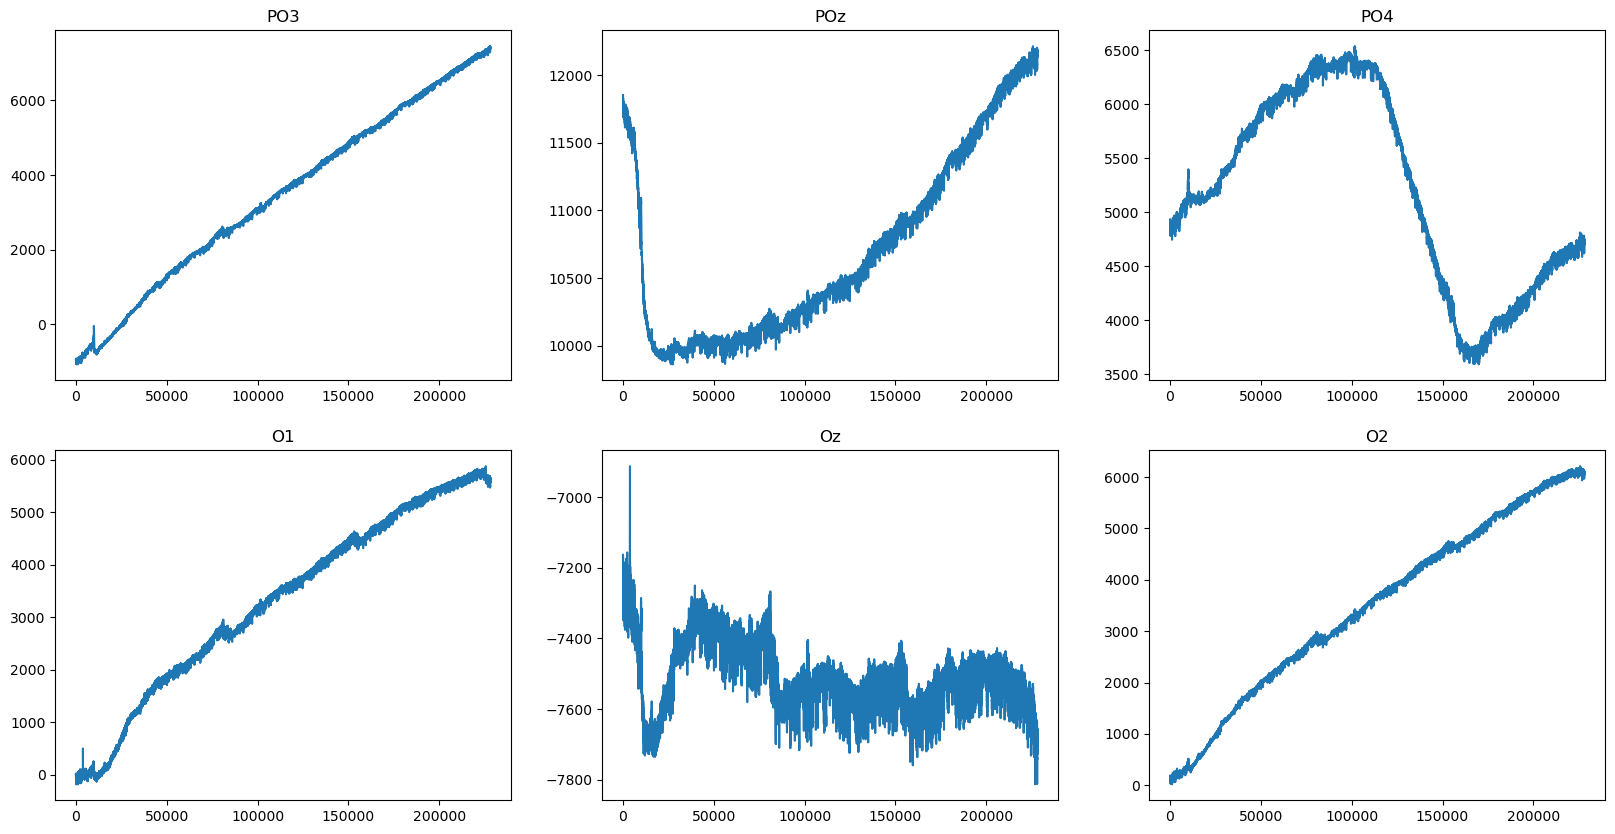

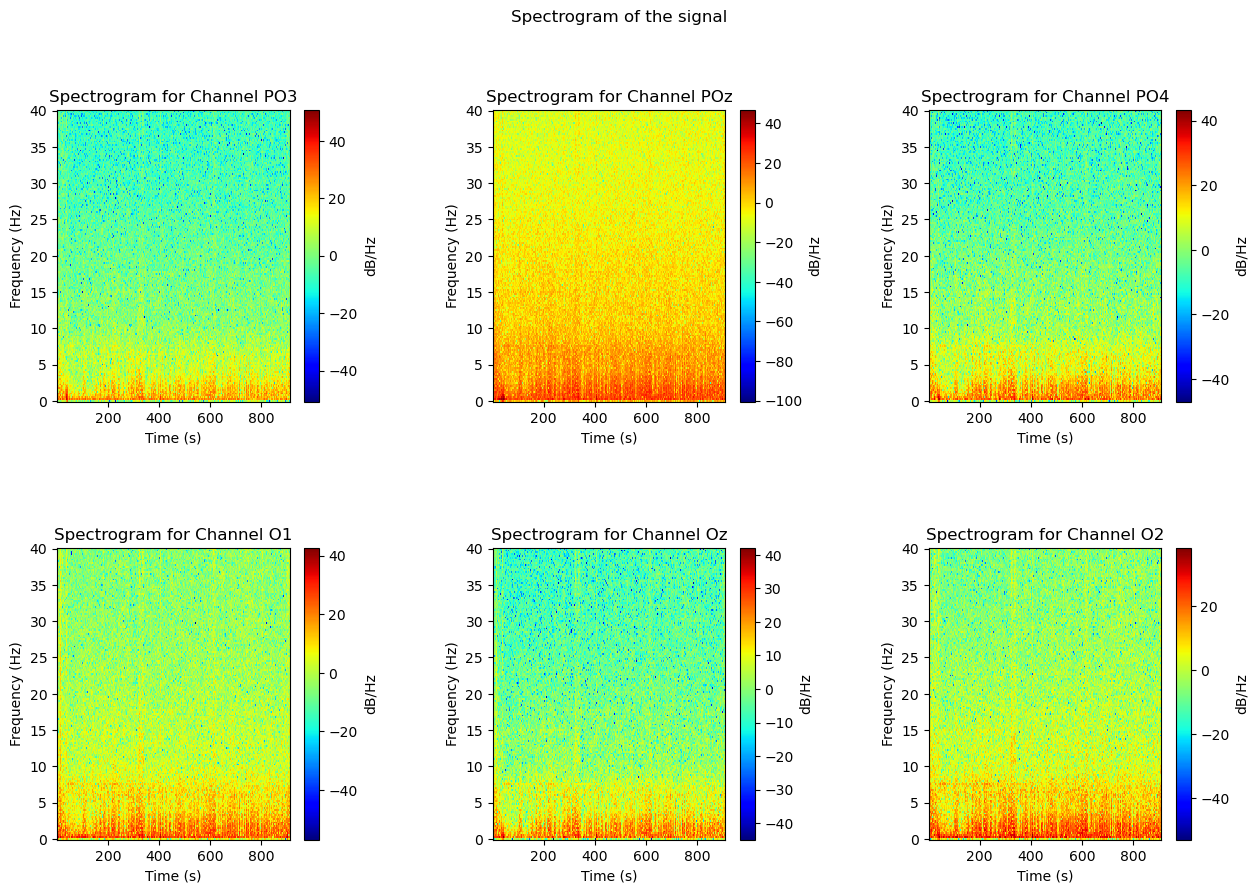

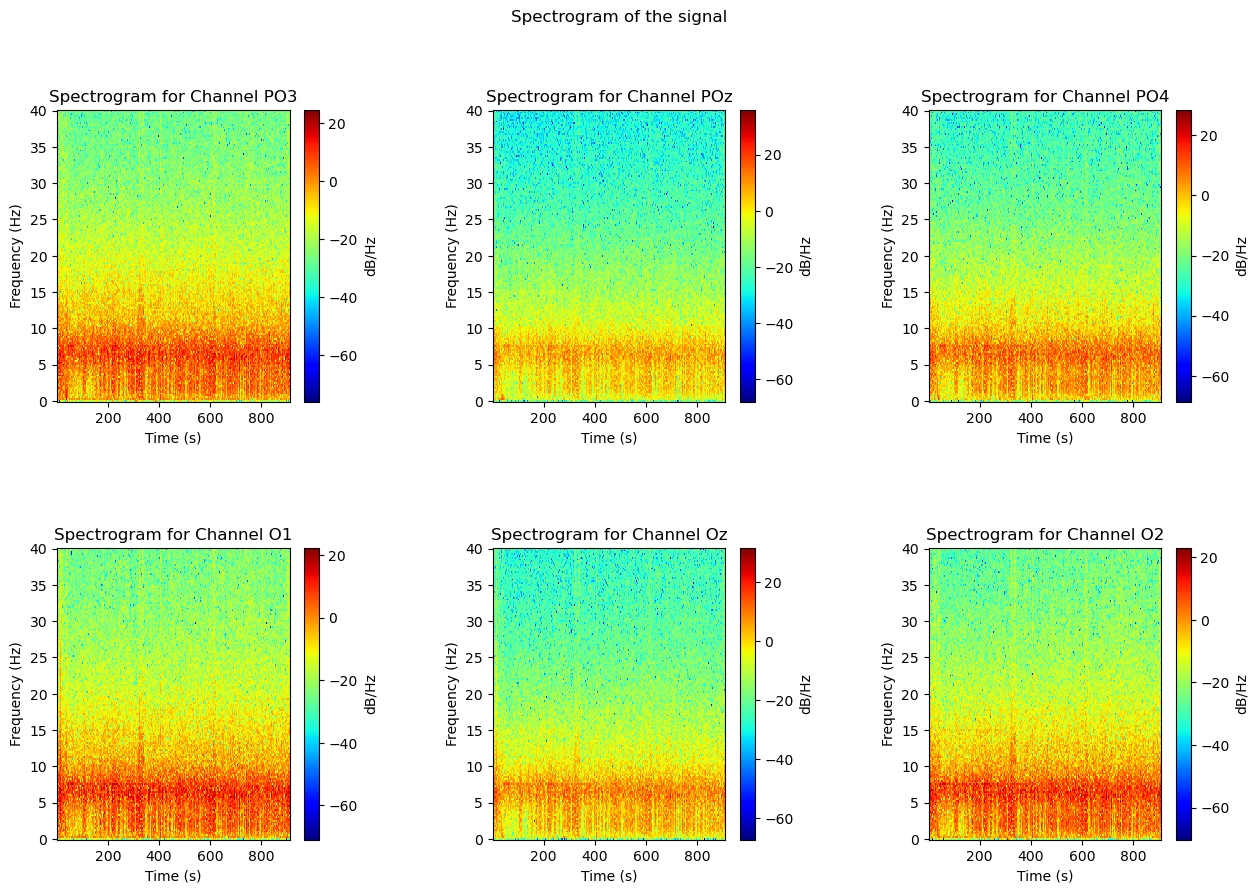

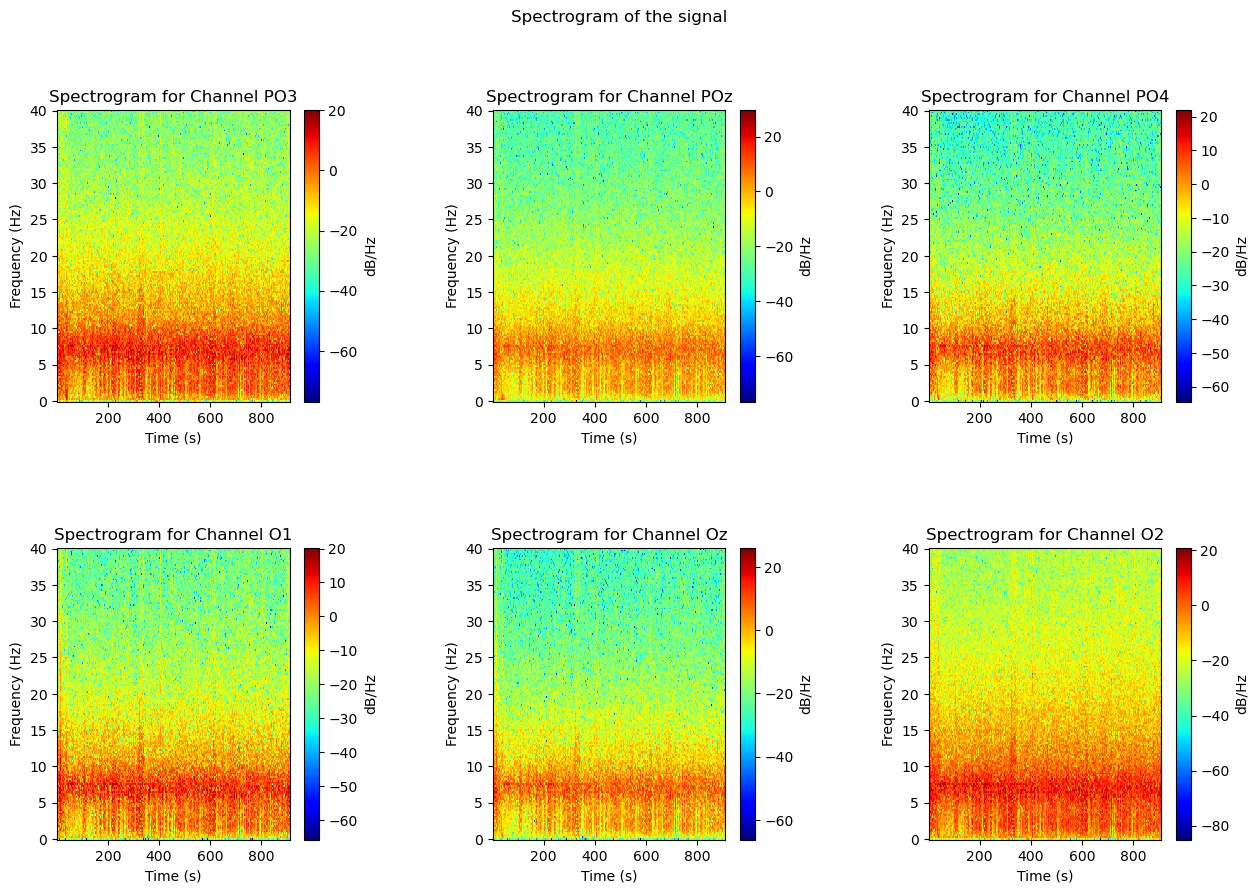

In [56]:
# Load csv files and extract information
# Load the raw EEG data
eeg_data = pd.read_csv("data/Participants/Participant 6 Data/2804_Participant_6_1_ExG.csv")

# Load the markers 
markers = pd.read_csv("data/Participants/Participant 6 Data/2804_Participant_6_1_Marker.csv")


# Match the time stamps of the markers to the time stamps of the EEG data and create an array containing the sample number and the corresponding marker
marker_array = []
for i in range(0,len(markers)):
    marker_array.append([np.argmin(np.abs(eeg_data['TimeStamp'].to_numpy()-markers['TimeStamp'][i])),markers['Code'][i]])

# Convert the marker array to a numpy array
marker_array = np.array(marker_array)

# Remove the first column which contains the time stamps
eeg_data = eeg_data.iloc[:,1:]

# Convert the data to a numpy array
eeg_data = eeg_data.to_numpy()
eeg_data = eeg_data.T

# Remove channels 4 and 8 
eeg_data = np.delete(eeg_data, [3,6], axis=0)

# Plot the raw EEG data channel by channel in a 2 x 3 grid 
fig, axs = plt.subplots(2, 3, figsize=(20,10))
for i in range(0,6):
    axs[i//3,i%3].plot(eeg_data[i,:])
    axs[i//3,i%3].set_title(chan_name[i])
    
# Keeping only the number in the markers
marker_array[:,1] = [int(i[3:]) for i in marker_array[:,1]]

# Convert the elements of the marker array to integers
marker_array = marker_array.astype(int)


# Extract markers for each experiment and trial using the new method
experiment0_trial0 = extract_trial_markers(marker_array, 0, 0)
experiment0_trial1 = extract_trial_markers(marker_array, 0, 1)
experiment0_trial2 = extract_trial_markers(marker_array, 0, 2)
experiment1_trial0 = extract_trial_markers(marker_array, 1, 0)
experiment1_trial1 = extract_trial_markers(marker_array, 1, 1)
experiment1_trial2 = extract_trial_markers(marker_array, 1, 2)
experiment2_trial0 = extract_trial_markers(marker_array, 2, 0)
experiment3_trial0 = extract_trial_markers(marker_array, 3, 0)
experiment3_trial1 = extract_trial_markers(marker_array, 3, 1)

# Create epochs for each trial using the new method
epochs0_trial0 = create_trial_epochs(eeg_data, experiment0_trial0)
epochs0_trial1 = create_trial_epochs(eeg_data, experiment0_trial1)
epochs0_trial2 = create_trial_epochs(eeg_data, experiment0_trial2)
epochs1_trial0 = create_trial_epochs(eeg_data, experiment1_trial0)
epochs1_trial1 = create_trial_epochs(eeg_data, experiment1_trial1)
epochs1_trial2 = create_trial_epochs(eeg_data, experiment1_trial2)
epochs2_trial0 = create_trial_epochs(eeg_data, experiment2_trial0)
epochs3_trial0 = create_trial_epochs(eeg_data, experiment3_trial0)
epochs3_trial1 = create_trial_epochs(eeg_data, experiment3_trial1)



# Filter the data for the 6.6 Hz Frequency
# Apply the recursive least squares filter to each of the channels in the EEG signal with a target frequency of 6.6 Hz
eeg66 = []
# Initialize a list to store the RLS filter coefficients
filter_coefficients66 = []

for i in range(len(eeg_data)):
    # Apply the RLS filter to the EEG signal
    sig, coeff = rls_filter(eeg_data[i],6.6,0.95,fs,1e-4)
    # Append the filtered signal to the list y_hat
    eeg66.append(sig)
    # Append the filter coefficients to the list filter_coefficients
    filter_coefficients66.append(coeff)

# Transpose all elements in the list y_hat so that they are in the same format as the EEG signal
for i in range(len(eeg66)):
    eeg66[i] = eeg66[i].T

# Rearrange y_hat so it has same dimensions as eeg_array 
eeg66 = np.array(eeg66)
eeg66 = np.reshape(eeg66, (eeg_data.shape[0], eeg_data.shape[1]))

## This part is for the RLS filter from the paper.
# Apply the recursive least squares filter to each of the channels in the EEG signal with a target frequency of 7.5 Hz
eeg75 = []
# Initialize a list to store the RLS filter coefficients
filter_coefficients75 = []

for i in range(len(eeg_data)):
    # Apply the RLS filter to the EEG signal
    sig, coeff = rls_filter(eeg_data[i],7.5,0.95,fs,1e-4)
    # Append the filtered signal to the list y_hat
    eeg75.append(sig)
    # Append the filter coefficients to the list filter_coefficients
    filter_coefficients75.append(coeff)

# Transpose all elements in the list y_hat so that they are in the same format as the EEG signal
for i in range(len(eeg75)):
    eeg75[i] = eeg75[i].T

# Rearrange y_hat so it has same dimensions as eeg_array 
eeg75 = np.array(eeg75)
eeg75 = np.reshape(eeg75, (eeg_data.shape[0], eeg_data.shape[1]))


# Plot spectrogram of the raw EEG data using spectrogram_cp function
freqs, t, Sxx = spectrogram_cp(eeg_data,fs,f_range,True,4,2,chan_name)
freq1,t1,Sxx1 = spectrogram_cp(eeg66,fs,f_range,True,4,2,chan_name)
freq2,t2,Sxx2 = spectrogram_cp(eeg75,fs,f_range,True,4,2,chan_name)
